In [54]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras import backend as K
import shap

In [ ]:
# import scipy
# import sklearn
# import matplotlib
# print(np.__version__)
# print(pd.__version__)
# print(scipy.__version__)
# print(sklearn.__version__)
# print(shap.__version__)
# print(tf.__version__)
# print(matplotlib.__version__)

In [3]:
f_peaks = './metabolite_data.csv'
df_peaks = pd.read_csv(f_peaks)
peak_list = df_peaks['exp_peak'].values
peak_tols = df_peaks['interval_width_da'].values
peak_names = df_peaks['compound_name'].values
print(peak_names)

['Pyruvate' 'Lactate' 'Malonate' 'Oxaloacetate' 'Fumarate' 'Succinate'
 'Octanoic acid' 'Glutarate' 'Malate' 'alpha-Ketoglutarate' 'Succinate'
 'Decanoic acid' 'Phosphoenolpyruvate' 'cis-Aconitate;Citrate' 'Glucose'
 'Oxalosuccinate' 'Citrate' 'cis-Aconitate' 'Glucose' 'Oxalosuccinate'
 'Tetradecanoic acid' 'Glucose 1-phosphate' 'Glycerate 1,3-biphosphate'
 'Palmitoleic acid' 'Oleic acid' 'Octadecanoic acid'
 'S-Acetyldihydrolipoamide-E' 'Hexadecanoic acid' 'Oleic acid'
 'Octadecanoic acid' 'L-Palmitoylcarnitine']


In [4]:
f_data = './ROI_data_final.csv'
df = pd.read_csv(f_data)
peak_ids = df.columns[4:].values
n_roi = df.shape[0]
n_peaks = len(peak_ids)

In [5]:
sample_ids = df['Sample ID'].values
patient_ids = np.array([int(s.split('.')[1].split('_')[0]) for s in sample_ids], dtype=np.int32)
patient_list, patient_counts = np.unique(patient_ids, return_counts=True)

In [6]:
def norm_array(x):
    return (x-x.min()) / (x.max()-x.min())


def assign_label_benign_tumour(anno):
    anno_l = anno.lower()
    if 'epithelium' in anno_l:
        if 'tumour' in anno_l:
            return 1
        elif 'benign' in anno_l:
            return 0
    else:
        return -1

annotations = df['Annotation'].values
anno_labels = np.array([assign_label_benign_tumour(anno) for anno in annotations], dtype=np.int32)
idx = (anno_labels>=0)
xdata_raw = df[peak_ids][idx].values
xdata = StandardScaler().fit_transform(xdata_raw)
ydata = anno_labels[idx]
pdata = patient_ids[idx]
ids = np.arange(idx.sum())

In [7]:
z_all = TSNE(init='pca', perplexity=np.sqrt(len(xdata))).fit_transform(xdata)

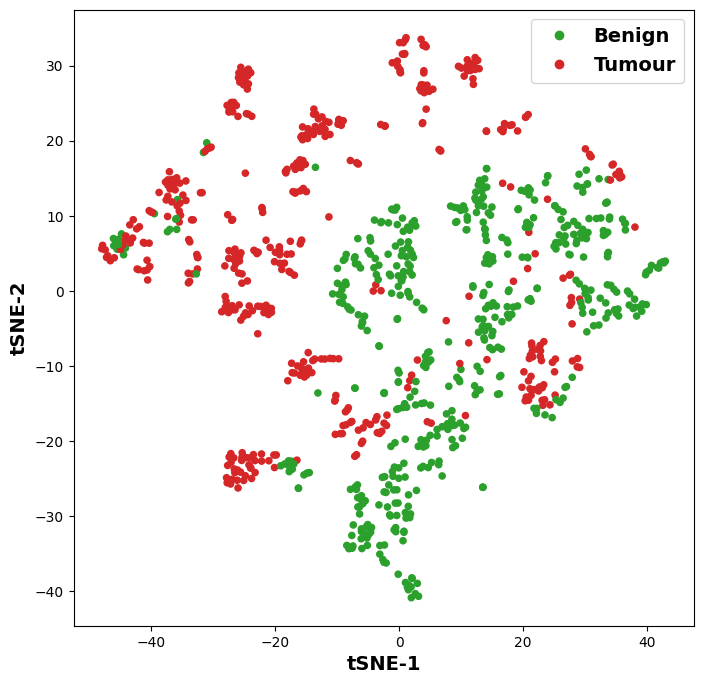

In [8]:
def assign_clabels(annos):
    clabels = []
    for a in annos:
        if 'benign' in a.lower():
            clabels.append(0)
        elif 'tumour' in a.lower():
            clabels.append(1)
        else:
            clabels.append(-1)
    return np.array(clabels, dtype=np.int32)

clabels = ydata

colors = ['tab:green', 'tab:red']
cmap = ListedColormap(colors)
labels = ['Benign', 'Tumour']
handles = [Line2D([], [], marker='o', ls='', color=col, label=lab) for col, lab in zip(colors, labels)]
legend_properties = {'weight':'bold', 'size': 14}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(z_all[:,0], z_all[:,1], s=20, c=clabels, cmap=cmap)
ax.legend(handles=handles, prop=legend_properties)
ax.set_xlabel('tSNE-1', weight='bold', fontsize=14)
ax.set_ylabel('tSNE-2', weight='bold', fontsize=14)
plt.show()

In [9]:
num_patients = len(np.unique(patient_ids[idx]))
print('%d unique patients'%num_patients)

13 unique patients


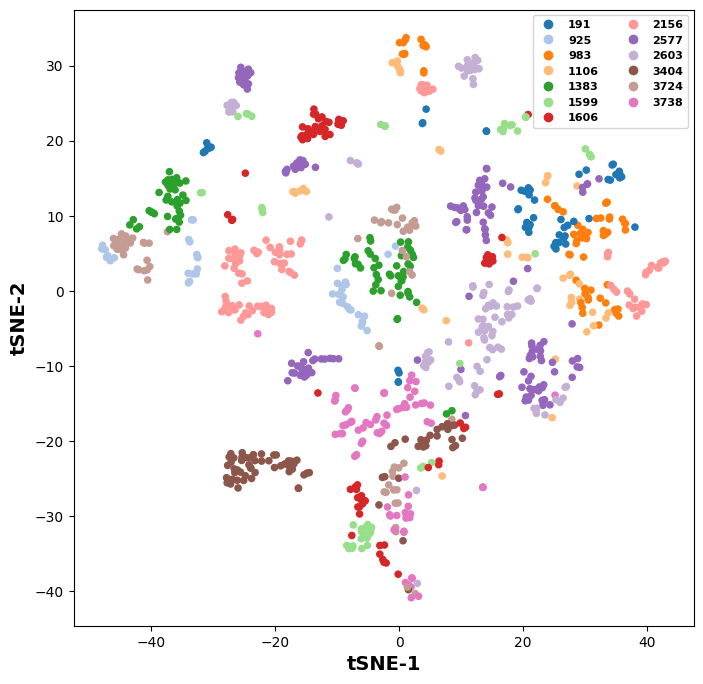

In [10]:
plist = np.unique(patient_ids[idx])
pdict = {p: i for i, p in enumerate(plist)}
clabels = [pdict[p] for p in patient_ids[idx]]

colors = [plt.cm.tab20(n) for n in range(len(patient_list))]
cmap = ListedColormap(colors)
handles = [Line2D([], [], marker='o', ls='', color=col, label=lab) for col, lab in zip(colors, plist)]
legend_properties = {'weight':'bold', 'size': 8}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(z_all[:,0], z_all[:,1], s=20, c=clabels, cmap=cmap)
ax.legend(handles=handles, prop=legend_properties, ncol=2)
ax.set_xlabel('tSNE-1', weight='bold', fontsize=14)
ax.set_ylabel('tSNE-2', weight='bold', fontsize=14)
plt.show()

In [55]:
def norm_array(x):
    ''' Scale array so all values lie between 0 and 1 '''
    return (x-x.min()) / (x.max() - x.min())


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def build_classifier(spec_shape, lr=1e-4, num_classes=1):
    inputs = layers.Input(shape=spec_shape)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2())(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2())(x)
    if num_classes==1:
        outputs = layers.Dense(1, activation='sigmoid')(x)
        model = models.Model(inputs=inputs, outputs=outputs)
        opt = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_m])
        return model
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs)
        opt = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    
def extract_features(classifier, data):
    extractor = models.Model(classifier.input, classifier.layers[-2].output)
    features = extractor.predict(data)
    return features


def spec_generator(data, labels, s_aug=0.1, batch_size=256):
    ''' Generator for training classifier on MSI data
        Data should be an NxM numpy array of N samples with M features
        Labels should be in the format required by the classifier (e.g. onehot)
        s_aug controls magnitude of data augmentation
            - augmentation consists of adding gaussian random noise to each value
            - magnitude of noise added to feature depends on average value of 
              feature and s_aug '''
    nsamp, samp_shape = data.shape
    i_mean = np.mean(data, axis=0)*s_aug
    while True:
        idx = np.random.choice(nsamp, size=batch_size)
        jitter = np.random.randn(batch_size, samp_shape)*s_aug
        yield data[idx]+jitter, labels[idx]

In [57]:
nfolds = 5
batch_size = 32

kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
results_dict = {}
results_dict['test_accuracy'] = np.zeros(nfolds)
results_dict['test_f1'] = np.zeros(nfolds)

neg = (ydata==0).sum()
pos = (ydata==1).sum()
total = len(ydata)
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

for n, (trainval_index, test_index) in enumerate(kf.split(patient_list)):
    
    ntrain = int(0.9*len(trainval_index))
    train_index = trainval_index[:ntrain]
    val_index = trainval_index[ntrain:]
    patients_train = patient_list[train_index]
    idx_train = np.isin(pdata, patients_train)
    patients_val = patient_list[val_index]
    idx_val = np.isin(pdata, patients_val)
    patients_test = patient_list[test_index]
    idx_test = np.isin(pdata, patients_test)
    x_train = xdata[idx_train]
    y_train = ydata[idx_train]
    x_val = xdata[idx_val]
    y_val = ydata[idx_val]
    x_test = xdata[idx_test]
    y_test = ydata[idx_test]
    
    spec_shape = x_train.shape[1:]
    classifier = build_classifier(spec_shape, lr=1e-4)
    cbs = [callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                      min_delta=1e-4, monitor='val_loss')]

    train_generator = spec_generator(x_train, y_train, s_aug=0.2, batch_size=batch_size)
    val_generator = spec_generator(x_val, y_val, s_aug=0, batch_size=batch_size)
    train_steps = len(x_train)//batch_size
    val_steps = len(x_val)//batch_size

    history = classifier.fit(train_generator, validation_data=val_generator, 
                             epochs=100, steps_per_epoch=train_steps,
                             validation_steps=val_steps, callbacks=cbs, verbose=0,
                             class_weight=class_weight)

    test_loss, test_acc, test_f1 = classifier.evaluate(x_test, y_test, verbose=0)
    results_dict['test_accuracy'][n] = test_acc
    results_dict['test_f1'][n] = test_f1
    results_dict['history_fold-%d'%(n+1)] = history.history
    
    features = extract_features(classifier, xdata)
    results_dict['features_fold-%d'%(n+1)] = features
    
    y_pred = classifier.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_test = auc(fpr, tpr)
    results_dict['fpr_fold-%d'%(n+1)] = fpr
    results_dict['tpr_fold-%d'%(n+1)] = tpr
    results_dict['auc_fold-%d'%(n+1)] = auc_test
    
    test_summary = shap.kmeans(x_train, 5)
    explainer = shap.KernelExplainer(classifier, test_summary)
    shap_vals = explainer.shap_values(x_test, l1_reg='aic', silent=True)
    results_dict['shap_vals_fold-%d'%(n+1)] = shap_vals
    results_dict['eval_data_fold-%d'%(n+1)] = x_test

    
print('Test accuracy: %.2f%%' %(100*np.mean(results_dict['test_accuracy'])))
print('Test F1: %.2f%%' %(100*np.mean(results_dict['test_f1'])))






Test accuracy: 84.68%
Test F1: 76.10%


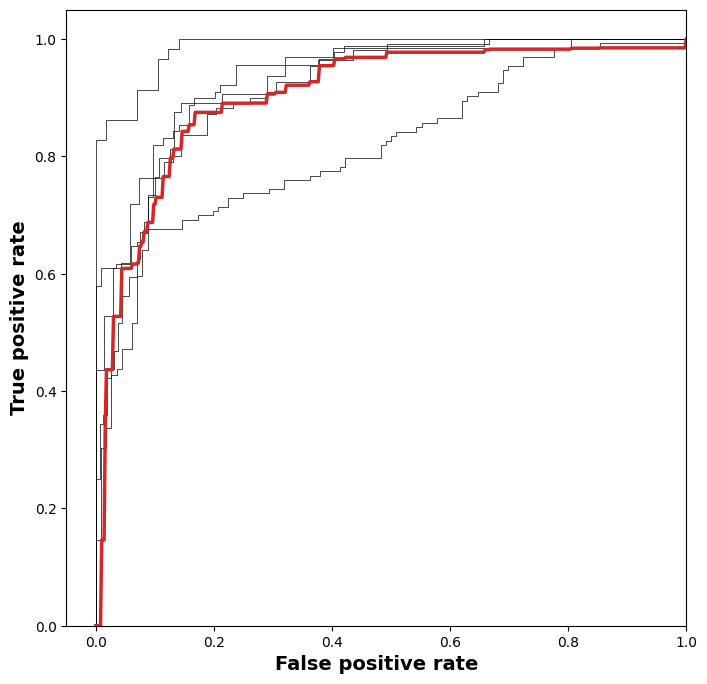

0.9026074886679288
0.9203627045140942


In [58]:
xaxis = np.linspace(0, 1, 500)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fpr_list, tpr_list = [], []
for n in range(5):
    fpr = results_dict['fpr_fold-%d'%(n+1)]
    tpr = results_dict['tpr_fold-%d'%(n+1)]
    fpr_u, index = np.unique(fpr, return_index=True)
    ax.plot(fpr, tpr, color='k', lw=0.5)
    f_tpr = interp1d(fpr_u, tpr[index], 0)
    fpr_list.append(xaxis)
    tpr_list.append(f_tpr(xaxis))
fpr_med = np.median(fpr_list, axis=0)
tpr_med = np.median(tpr_list, axis=0)
tpr_med[0] = 0
ax.plot(fpr_med, tpr_med, lw=2.5, color='tab:red')
ax.set_xlim(None, 1)
ax.set_ylim(0, None)
ax.set_xlabel('False positive rate', weight='bold', fontsize=14)
ax.set_ylabel('True positive rate', weight='bold', fontsize=14)
plt.show()

print(auc(fpr_med, tpr_med))
print(np.median([results_dict['auc_fold-%d'%(n+1)] for n in range(5)]))

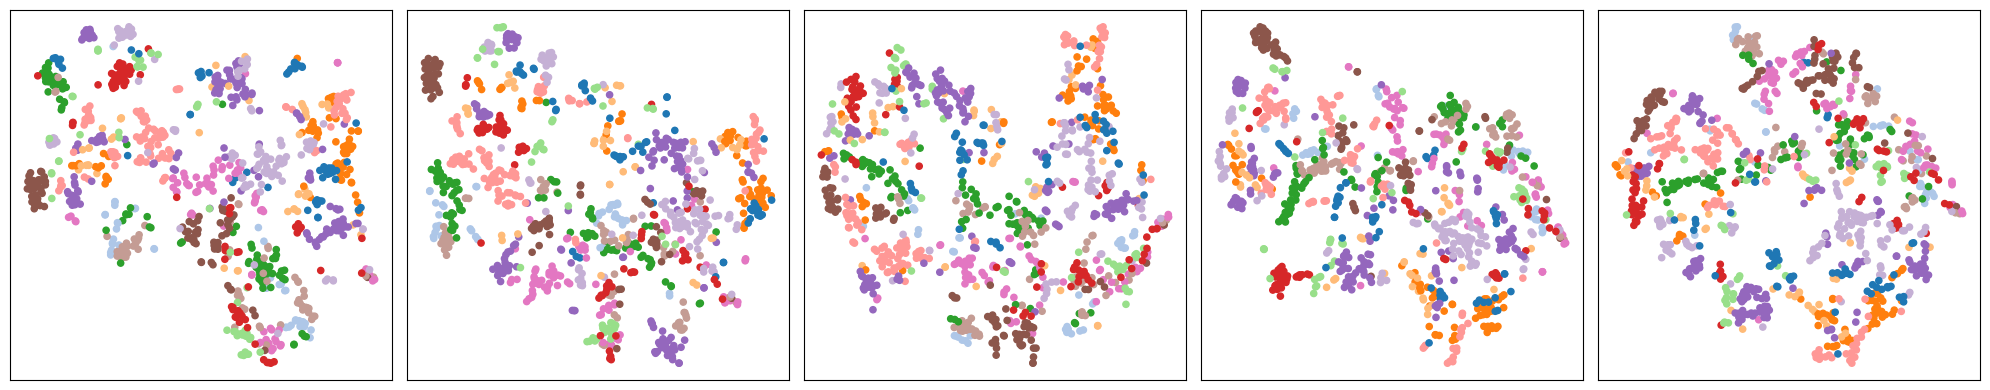

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for n, ax in enumerate(axes):
    feats = results_dict['features_fold-%d'%(n+1)]
    z_feats = TSNE(init='pca', perplexity=30).fit_transform(feats)
    ax.scatter(z_feats[:,0], z_feats[:,1], s=20, c=clabels, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

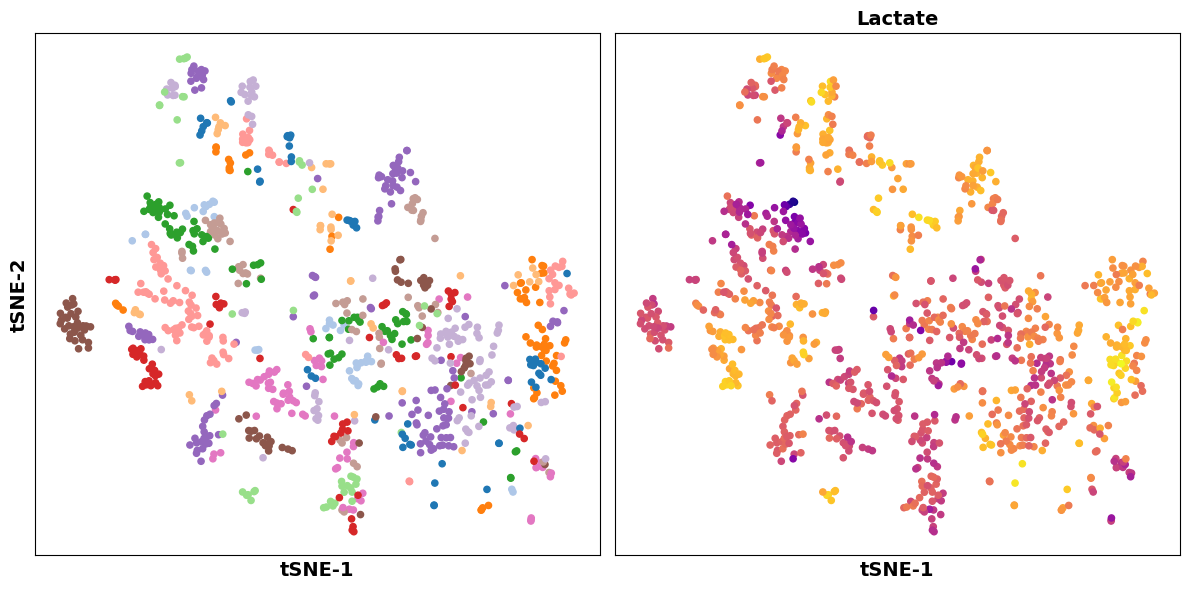

In [60]:
n = 1
feats = results_dict['features_fold-%d'%(n+1)]
z_feats = TSNE(init='pca', perplexity=30).fit_transform(feats)

k = 1

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].scatter(z_feats[:,0], z_feats[:,1], s=20, c=clabels, cmap=cmap)
axes[1].scatter(z_feats[:,0], z_feats[:,1], s=20, c=xdata[:,k], cmap='plasma')
axes[1].set_title(peak_names[k], weight='bold', fontsize=14)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('tSNE-1', weight='bold', fontsize=14)
axes[0].set_ylabel('tSNE-2', weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [61]:
shap_scores = np.zeros(xdata.shape)
eval_data = np.zeros(xdata.shape)
n = 0
for i in range(nfolds):
    shaps = results_dict['shap_vals_fold-%d'%(i+1)]
    xtest = results_dict['eval_data_fold-%d'%(i+1)]
    k = len(xtest)
    shap_scores[n:n+k] = shaps[:,:,0]
    eval_data[n:n+k] = xtest
    n += k

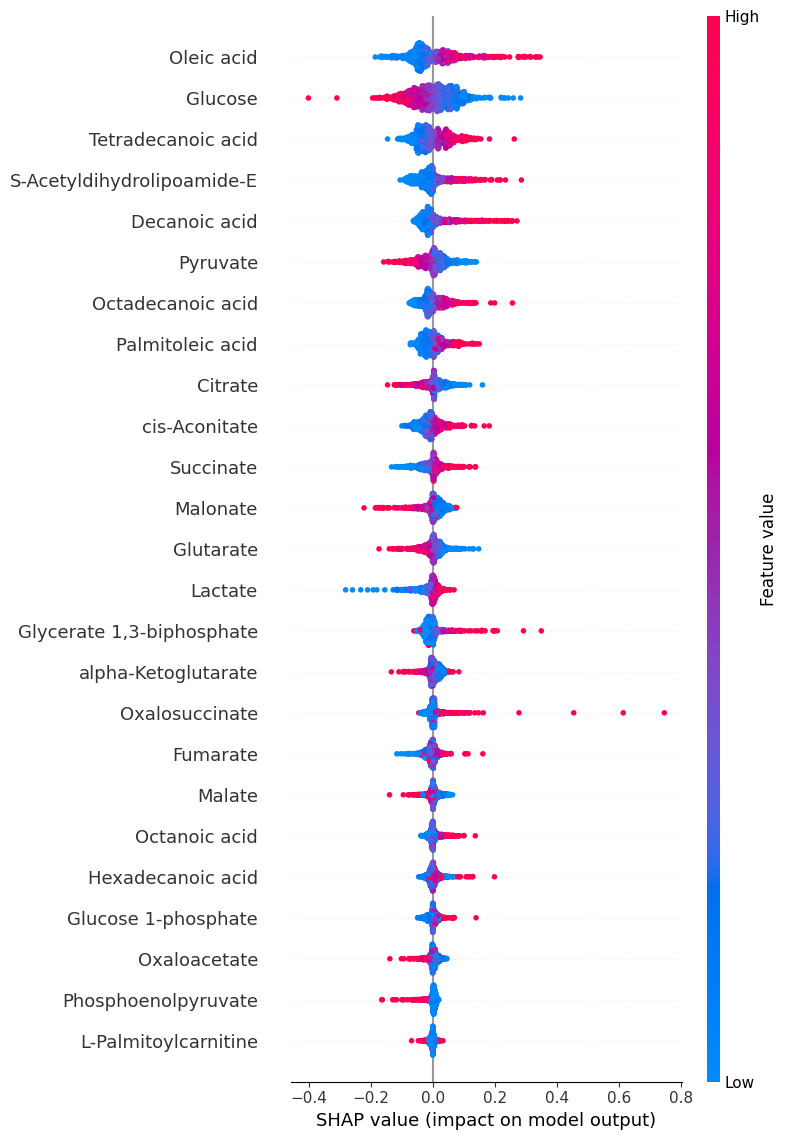

In [62]:
peak_names_short = [pn.split(';')[-1] for pn in peak_names]
peak_names_shap, ui = np.unique(peak_names_short, return_index=True)

shap.summary_plot(shap_scores[:,ui], eval_data[:,ui], feature_names=peak_names_shap, max_display=len(peak_names_shap))

In [63]:
# np.save('shap_scores', shap_scores)
# np.save('eval_data', eval_data)
# np.save('peak_names_shap', peak_names_shap)

In [64]:
for i, peak_name in enumerate(peak_names_shap):
    print(peak_name, np.mean(np.abs(shap_scores[:,ui][:,i])))

Citrate 0.02601475734265103
Decanoic acid 0.03439190744841719
Fumarate 0.013449587019777574
Glucose 0.05494338981793461
Glucose 1-phosphate 0.010889654223328942
Glutarate 0.021764637770443077
Glycerate 1,3-biphosphate 0.018804728440672724
Hexadecanoic acid 0.011047721829151176
L-Palmitoylcarnitine 0.0059309557034135235
Lactate 0.019547908392282935
Malate 0.011784306630154243
Malonate 0.022216317190652084
Octadecanoic acid 0.028043016057813046
Octanoic acid 0.011551623870263102
Oleic acid 0.05630961521799077
Oxaloacetate 0.010392632315606744
Oxalosuccinate 0.013680412245678756
Palmitoleic acid 0.02641296985268483
Phosphoenolpyruvate 0.008300126984603072
Pyruvate 0.03178395067199941
S-Acetyldihydrolipoamide-E 0.037242931458947345
Succinate 0.02343320085808446
Tetradecanoic acid 0.0406080443895635
alpha-Ketoglutarate 0.0148548197674242
cis-Aconitate 0.025552783601468055
